In [1]:
import contextlib
from datetime import datetime
from fastai import *
from fastai.tabular import *
import io
import pandas as pd
from pathlib import Path
import random

In [2]:
DATA_PATH = Path('../../data/interim')
path = Path('../../models/')

In [3]:
# Import train_valid_data and test_data dataframes
train_valid_df_raw = pd.read_csv(DATA_PATH/'train_valid_data.csv', low_memory=False)
train_valid_df = train_valid_df_raw.copy()

train_valid_df.sort_values('date')

# Drop week_start as that will get taken into account by add_datepart() for date
train_valid_df.drop('week_start', axis='columns', inplace=True)

# Drop any rows where sales = 0 since we don't need to forecast those
train_valid_df = train_valid_df[train_valid_df.sales != 0]

# Run tabular.add_datepart() on both dfs to add columns about the date: ['Year', 'Month', 'Week', 'Day', 'Dayofweek',
# 'Dayofyear', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
tabular.add_datepart(train_valid_df, 'date', drop=True, time=False)

# Category names, to which we'll apply embeddings
cat_names = ['assortment', 'events', 'promo_interval', 'state', 'state_holiday', 'store_type']

# Add the date-related categories
cat_names += ['Day', 'Dayofweek', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end',
              'Is_year_start', 'Month', 'Week', 'Year',]

# Continuous-variable names, which we'll make sure are all represented as floats
# Just use set difference to make sure everything is covered
cont_names = list(set(train_valid_df.columns) - set(cat_names))

# Set up transforms to 1) replace missing values for continuous variables by the median column value, 2) transform all
# categorical variables into categories, 3) normalize continuous variables.
# Note that FillMissing should do nothing since we shouldn't have any NaNs -- leaving it in anyway
procs = [FillMissing, Categorify, Normalize]

df = train_valid_df

# Validation set is 
valid_idx = range(int(0.8 * len(df)), len(df))
dep_var = 'sales'

data = (TabularList.from_df(df, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                   .split_by_idx(valid_idx)
                   .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                   .databunch())

data.show_batch()

assortment,events,promo_interval,state,state_holiday,store_type,Day,Dayofweek,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Month,Week,Year,school_holiday,max_wind_speed_km_h,max_gust_speed_km_h,sales,max_sea_level_pressureh_pa,dew_point_c,precipitationmm,competition_open_since_month,mean_dew_point_c,mean_visibility_km,max_temperature_c,wind_dir_degrees,competition_open_since_year,customers,promo2,mean_humidity,store,min_sea_level_pressureh_pa,min_dew_point_c,promo,Elapsed,max_humidity,cloud_cover,mean_wind_speed_km_h,max_visibility_km,promo2_since_year,min_humidity,competition_distance,Dayofyear,min_visibility_km,open,min_temperature_c,mean_sea_level_pressureh_pa,mean_temperature_c,promo2_since_week,day_of_week,trend,target
a,Fog,"Feb,May,Aug,Nov",NW,0,d,14,4,False,False,False,False,False,False,3,11,2014,-0.4785,-1.1674,0.0084,-0.6132,1.2893,-0.4741,-0.3089,0.0054,-0.5947,-0.6138,0.2705,1.1336,-0.0321,-0.7200,1.0334,-0.6068,-0.7848,0.8639,-0.6651,-0.8994,0.0204,0.3136,0.0920,-1.2424,-0.4585,-2.3981,-1.0198,0.4561,-0.8424,-0.9059,0.0000,-1.0254,1.2695,-0.2237,1.3606,0.8574,-0.4784,8.551015
c,Fog-Snow,"Jan,Apr,Jul,Oct",BY,0,a,25,0,False,False,False,False,False,False,2,9,2013,-0.4785,-0.8316,0.0084,-0.6845,0.4250,-1.7907,-0.3089,-1.9911,-1.7760,-1.4935,-1.4128,1.1976,-0.1657,-0.4977,1.0334,0.9351,0.3349,0.0818,-2.1761,-0.8994,-1.4654,0.8369,0.3780,-0.2451,-1.5401,-1.5211,0.4547,-0.4038,-1.0053,-1.1269,0.0000,-2.4395,0.2028,-1.9099,1.5700,-1.4616,-1.7183,8.507143
a,Rain,None,NW,0,a,2,4,False,False,False,False,False,False,5,18,2014,-0.4785,-0.0478,0.0084,-0.0910,0.5485,0.5133,-0.3089,0.0054,0.4179,-0.3938,-0.2104,1.8904,-0.0321,0.0330,-0.9677,0.6267,-0.4229,-0.1417,0.1744,1.1118,0.2110,0.1828,1.0155,0.2536,0.2987,0.0256,0.4547,-0.6384,-0.3729,-0.9059,0.0000,0.3888,0.0842,0.0574,-0.0432,0.8574,1.1429,8.824531
b,Rain,None,NW,0,b,18,5,False,False,False,False,False,False,1,3,2014,-0.4785,0.6240,0.0084,2.1368,-1.9211,-0.8033,-0.3089,1.0660,-0.5947,-0.3938,-0.4509,-0.3160,-1.9636,6.1506,-0.9677,-0.8380,0.5267,-1.5942,-0.4972,-0.8994,-0.1935,-2.3026,1.0155,1.0848,-1.4320,0.0256,-0.1046,-0.5598,-1.3695,0.6415,0.0000,-0.0826,-1.6937,-0.2237,-0.0432,1.4372,-1.1460,9.528067
c,Rain,"Jan,Apr,Jul,Oct",HE,0,a,12,2,False,False,False,False,False,False,2,7,2014,-0.4785,0.2881,-1.0334,-1.1736,-0.8098,-0.8033,0.1140,0.0054,-0.7635,-0.3938,-0.6914,0.1423,-0.0321,-0.6518,1.0334,-0.1442,0.4246,-1.1473,-0.6651,-0.8994,-0.0963,0.8369,-0.2595,0.2536,-0.9993,1.1100,-0.3588,-0.5636,-1.1299,0.6415,0.0000,-0.5540,-0.8640,-0.5047,0.3134,-0.3021,-0.0970,8.139149


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


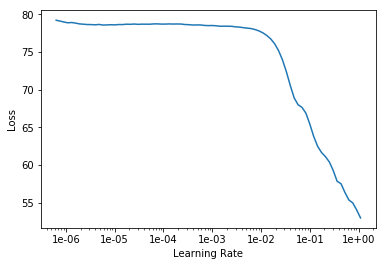

In [4]:
max_y = np.max(df['sales'])
y_range = torch.tensor([0, np.log(max_y*1.2)], device=defaults.device)
#learn = tabular_learner(data, layers=[100,100], ps=[0.001, 0.01], emb_drop=0.01, metrics=exp_rmspe, y_range=y_range,
learn = tabular_learner(data, layers=[100,100], ps=[0.001, 0.01], emb_drop=0.01, metrics=exp_rmspe, y_range=None,
                        callback_fns=[partial(callbacks.tracker.TrackerCallback, monitor='exp_rmspe'),
                                      partial(callbacks.tracker.EarlyStoppingCallback, mode='min',
                                              monitor='exp_rmspe', min_delta=0.01, patience=1),
                                      partial(callbacks.tracker.SaveModelCallback, monitor='exp_rmspe', mode='min',
                                              every='improvement',
                                              name=datetime.now().strftime("%Y-%m-%d-%X"))])

learn.lr_find()
learn.recorder.plot()

In [6]:
import random
random.seed(42)
learn.fit_one_cycle(cyc_len=10, max_lr=1e-3)

epoch,train_loss,valid_loss,exp_rmspe
1,0.013776,0.001579,0.035613
2,0.014646,0.001341,0.029947


Epoch 3: early stopping


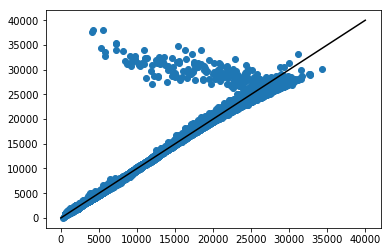

In [7]:
train_log_preds, train_log_reals = learn.get_preds(ds_type=DatasetType.Train)
train_preds = np.exp(train_log_preds).flatten()
train_reals = np.exp(train_log_reals)
train_sub = pd.DataFrame({'Predicted': train_preds, 'Actual': train_reals})
fig, ax = plt.subplots()
ax.scatter(train_sub.Predicted, train_sub.Actual)
ax.plot(np.linspace(0,40000,5000), np.linspace(0,40000,5000), color='black')

In [10]:
def rmspe(predicted, actual):
    return np.sqrt((((actual - predicted)/actual)**2).sum()/len(actual))

rmspe(train_sub.Predicted.values, train_sub.Actual.values)

0.030267978225560738

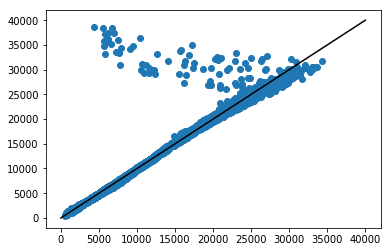

In [8]:
log_preds, log_reals = learn.get_preds(ds_type=DatasetType.Valid)
preds = np.exp(log_preds).flatten()
reals = np.exp(log_reals)
sub = pd.DataFrame({'Predicted': preds, 'Actual': reals})
fig, ax = plt.subplots()
ax.scatter(sub.Predicted, sub.Actual)
ax.plot(np.linspace(0,40000,5000), np.linspace(0,40000,5000), color='black')

In [9]:
rmspe(sub.Predicted.values, sub.Actual.values)

0.032206698659979445

In [8]:
learn.path

PosixPath('../../models')

In [11]:
learn.save('ghosting_left_high_end0.0322')
learn.export()

In [12]:
# Import test_data dataframe and prep for use
test_df_raw = pd.read_csv(DATA_PATH/'test_data.csv', low_memory=False)
test_df = test_df_raw.copy()

# Drop week_start as that will get taken into account by add_datepart() for date
test_df.drop('week_start', axis='columns', inplace=True)

# Drop any rows where sales = 0 since we don't need to forecast those
test_df = test_df[test_df.sales != 0]

# Run tabular.add_datepart() on both dfs to add columns about the date: ['Year', 'Month', 'Week', 'Day', 'Dayofweek',
# 'Dayofyear', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
tabular.add_datepart(test_df, 'date', drop=True, time=False)

# Category names, to which we'll apply embeddings
cat_names = ['assortment', 'events', 'promo_interval', 'state', 'state_holiday', 'store_type']

# Add the date-related categories
cat_names += ['Day', 'Dayofweek', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end',
              'Is_year_start', 'Month', 'Week', 'Year',]

# Continuous-variable names, which we'll make sure are all represented as floats
# Just use set difference to make sure everything is covered
cont_names = list(set(train_valid_df.columns) - set(cat_names))

# Set up transforms to 1) replace missing values for continuous variables by the median column value, 2) transform all
# categorical variables into categories, 3) normalize continuous variables.
# Note that FillMissing should do nothing since we shouldn't have any NaNs -- leaving it in anyway
procs = [FillMissing, Categorify, Normalize]

In [13]:
learn = load_learner('../../models',
                      test=TabularList.from_df(test_df, path=path))
                      #.no_split()
                      #.label_from_df(cols=dep_var, label_cls=FloatList, log=True))

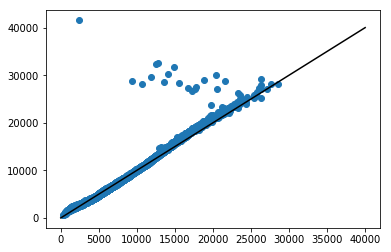

In [14]:
log_test_preds, log_test_reals = learn.get_preds(ds_type=DatasetType.Test)
test_preds = np.exp(log_test_preds).flatten()
#test_reals = np.exp(log_test_reals)
test_reals = test_df_raw.loc[test_df_raw.sales != 0, 'sales'].values
test_sub = pd.DataFrame({'Predicted': test_preds, 'Actual': test_reals})
fig, ax = plt.subplots()
ax.scatter(test_sub.Predicted, test_sub.Actual)
ax.plot(np.linspace(0,40000,5000), np.linspace(0,40000,5000), color='black')

In [15]:
rmspe(test_sub.Predicted.values, test_sub.Actual.values)

0.048635791657389196

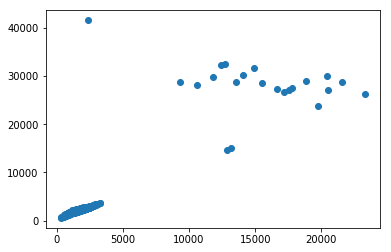

In [19]:
wrongs = test_sub[np.abs((test_sub.Predicted - test_sub.Actual) / test_sub.Actual) > 0.1]
#len(wrongs)/len(test_sub) # 0.0205
#len(wrongs) # 827
#plt.scatter(wrongs.Predicted, wrongs.Actual)

In [26]:
wrong_and_big = test_sub[(np.abs((test_sub.Predicted - test_sub.Actual) / test_sub.Actual) > 0.1) &
                         (test_sub.Actual > 10000)]
len(wrong_and_big) # 22
#plt.scatter(wrong_and_big.Predicted, wrong_and_big.Actual)

22

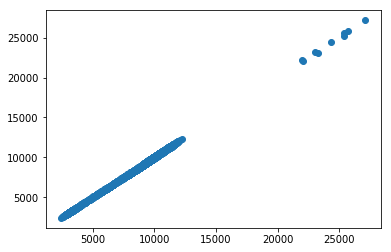

In [23]:
close = test_sub[np.abs((test_sub.Predicted - test_sub.Actual) / test_sub.Actual) < 0.01]
len(close)/len(test_sub) # 0.1657564172583288
len(close) # 6677
plt.scatter(close.Predicted, close.Actual)

In [27]:
test_sub.head(15)

,Predicted,Actual
0,4118.318359,4097.0
1,9157.336914,9351.0
2,6951.813965,6895.0
3,7528.446777,7656.0
4,5961.463867,6039.0
5,5058.627930,5135.0
6,7446.750488,7604.0
7,4303.449707,4318.0
8,5646.305664,5823.0
9,6030.148438,6125.0
